In [2]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import numpy as np
import matplotlib.pyplot as plt
import jax
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
import jax.numpy as jnp
from sklearn.model_selection import train_test_split
from scipy.signal import upfirdn
from commpy.filters import rrcosfilter

In [ ]:
#load data
data = np.load("green_machine_results_lorenz.npz", allow_pickle=True)["results"]

In [ ]:
#unwrap dictionary from numpy object array
def unwrap_dict(x):
    
    if isinstance(x, dict):
        return x
    
    if isinstance(x, np.ndarray) and x.dtype == object:
        if x.ndim == 0:
            return x.item()          
        elif x.ndim == 1 and x.size == 1:
            return x[0]
    raise TypeError(f"Don't know how to unwrap type: {type(x)} (dtype={getattr(x,'dtype',None)})")

l = unwrap_dict(data)
print("top-level keys:", list(l.keys()))
keys = l.keys()
mask = []
for key in keys:
    if "in" in key:
        mask.append(key)
print(mask)
for key in mask:
    l.pop(key)
print(l.keys())

top-level keys: ['out0', 'out4', 'out1', 'out5', 'out2', 'out6', 'out3', 'out7']
[]
dict_keys(['out0', 'out4', 'out1', 'out5', 'out2', 'out6', 'out3', 'out7'])


In [ ]:
#generate lorenz data and narma data
sigma, rho, beta = 10.0, 28.0, 8/3
N = 10000
def lorenz(t, xyz):
    x, y, z = xyz
    return [sigma*(y - x), x*(rho - z) - y, x*y - beta*z]


dtt = 0.05
upsample = 1

T = dtt * (N - 1)

dt_fine = dtt / upsample
t_fine = np.arange(0.0, T + 1e-12, dt_fine)

sol_fine = solve_ivp(
    lorenz, (0.0, T), (0., 1., 1.05),
    method="RK45", max_step=dt_fine, t_eval=t_fine
)
x_f, y_f, z_f = sol_fine.y

def minmax(u):
    return (u - u.min())/(u.max() - u.min())

y       = minmax(z_f)

print(len(y))


def narma7(N, seed=0, u_low=0.0, u_high=0.5, burn_in=1000):
    rng = np.random.default_rng(seed)
    U = rng.uniform(u_low, u_high, size=N + burn_in + 10)
    Y = np.zeros_like(U)
    for t in range(6, N + burn_in): 
        s = np.sum(Y[t-6:t+1])       
        Y[t+1] = 0.3 * Y[t] + 0.05 * Y[t] * s + 1.5 * U[t-6] * U[t] + 0.1
    u = U[burn_in+1:burn_in+1+N]
    y = Y[burn_in+1:burn_in+1+N]
    return u, y

u,y_narma = narma7(N, seed=42)
print(len(y_narma))



10000
10000
(10000,)


In [ ]:
#prepare data for neural network
X = np.stack(
    [v["output"].amplitude[214::512, :, 0] for v in l.values()],
    axis=0
)
X = X.transpose(1, 2, 0)
print("X shape:", X.shape)
X =X.reshape(X.shape[0], int(X.shape[1]*X.shape[2]))
print("X reshaped shape:", X.shape)


X shape: (10000, 5, 8)
X reshaped shape: (10000, 40)
[0.11273357-0.07689822j 0.106677  -0.08280347j 0.09835879-0.08550612j
 0.0910526 -0.08784276j 0.09071339-0.08996257j 0.09956201-0.08712049j
 0.10937687-0.0748883j  0.11201293-0.05575179j 0.10967644-0.03852364j
 0.10768713-0.018428j  ]


In [ ]:
#data preprocessing functions

def data_shape(data, delay=0, sps=1, time_multiplex_var=50):
    x = data() if callable(data) else data
    per_symbol = x[delay::sps, :]
    n_sym, n_ch = per_symbol.shape
    n_blocks = n_sym // time_multiplex_var
    per_symbol = per_symbol[:n_blocks * time_multiplex_var]
    X = per_symbol.reshape(n_blocks, time_multiplex_var * n_ch)
    return X

def train_test_split_embargo(X,train_frac = 0.7,validation_frac=0.2,test_frac = 0.1, embargo = 0):
    N = X.shape[0]
    split_train = int(np.floor(train_frac * N))
    split_val = int(np.floor((train_frac + validation_frac) * N))
    lo = max(0, split_train - embargo)
    mid = min(N, split_train + embargo)
    hi = min(N, split_val + embargo)
    X_train = X[0:lo]
    X_validation = X[mid:hi]
    X_test = X[hi:]

    return X_train, X_validation, X_test

def train_test_split_labels(y,train_frac = 0.7, validation_frac=0.2, test_frac=0.1, embargo = 0):
    N = len(y)
    split_train = int(np.floor(train_frac * N))
    split_val = int(np.floor((train_frac + validation_frac) * N))
    lo = max(0, split_train - embargo)
    mid = min(N, split_train + embargo)
    hi = min(N, split_val + embargo)
    Y_train = y[0:lo]
    Y_validation = y[mid:hi]
    Y_test = y[hi:]
    return Y_train, Y_validation, Y_test


X_train, X_validation, X_test = train_test_split_embargo(X[1000:-1001], train_frac=0.7, validation_frac=0.2, test_frac=0.1)
Y_train, Y_validation, Y_test = train_test_split_labels(y[1001:-1000], train_frac=0.7,validation_frac=0.2)

#normalize data
umin = X_train.min(axis=0, keepdims=True)
umax = X_train.max(axis=0, keepdims=True)
X_train = (X_train - umin) / (umax - umin + 1e-12)
X_validation = (X_validation - umin) / (umax - umin + 1e-12)
X_test = (X_test - umin) / (umax - umin + 1e-12)

print(X_train.shape,X_test.shape,X_validation.shape)
print(Y_train.shape,Y_test.shape,Y_validation.shape)

(5599, 40) (800, 40) (1600, 40)
(5599,) (800,) (1600,)


In [ ]:
#define neural network model
class InterferometricRegressor(nn.Module):
    def __init__(self, n_pos, n_neg):
        super().__init__()
        self.wpos = nn.Parameter(torch.randn(n_pos, dtype=torch.cfloat))
        self.wneg = nn.Parameter(torch.randn(n_neg, dtype=torch.cfloat))
        self.bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, xpos, xneg):
        pos = torch.sum(self.wpos * xpos, dim=1)
        neg = torch.sum(self.wneg * xneg, dim=1)
        return pos.abs()**2 - neg.abs()**2 + self.bias

Y_train_np = np.array(Y_train, copy=True)
Y_test_np  = np.array(Y_validation,  copy=True)

xpos_train, xneg_train = X_train[:,:20], X_train[:,20:45]
xpos_test, xneg_test = X_validation[:,:20], X_validation[:,20:45]

xpos_train_torch = torch.tensor(xpos_train, dtype=torch.cfloat)
xneg_train_torch = torch.tensor(xneg_train, dtype=torch.cfloat)
y_train_torch = torch.tensor(Y_train_np, dtype=torch.float32)

xpos_test_torch = torch.tensor(xpos_test, dtype=torch.cfloat)
xneg_test_torch = torch.tensor(xneg_test, dtype=torch.cfloat)
y_test_torch = torch.tensor(Y_test_np, dtype=torch.float32)

model = InterferometricRegressor(
    n_pos = xpos_train.shape[1],
    n_neg = xneg_train.shape[1]
)
class RMSELoss(nn.Module):
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true) + self.eps)

mse_loss = nn.MSELoss()

optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,            
    max_iter=100,       
    history_size=100,
    line_search_fn='strong_wolfe',
    tolerance_grad=1e-10,
    tolerance_change=1e-10,

)
path = "model.pth"
def closure():
    optimizer.zero_grad()
    y_pred = model(xpos_train_torch, xneg_train_torch)
    loss = mse_loss(y_pred, y_train_torch)
    loss.backward()
    return loss

best_r2_test = 0
n_epochs = 25
for epoch in range(n_epochs):
    
    loss = optimizer.step(closure)  # after this, params have changed

    model.eval()
    with torch.no_grad():
        y_pred_train = model(xpos_train_torch, xneg_train_torch)
        y_pred_test  = model(xpos_test_torch,  xneg_test_torch)

        train_mse = mse_loss(y_pred_train, y_train_torch)
        test_mse  = mse_loss(y_pred_test,  y_test_torch)

        train_rmse = torch.sqrt(train_mse + 1e-6).item()
        test_rmse  = torch.sqrt(test_mse + 1e-6).item()

        r2_train = (1 - torch.sum((y_train_torch - y_pred_train)**2) /
                        torch.sum((y_train_torch - y_train_torch.mean())**2)).item()
        r2_test  = (1 - torch.sum((y_test_torch  - y_pred_test )**2) /
                        torch.sum((y_test_torch  - y_test_torch.mean())**2)).item()
        
        if r2_test > best_r2_test:
            best_r2_test = r2_test
            
            torch.save(model, path)
            print(f"New best model saved with Test R² = {best_r2_test:.6f}")
        
        

    print(f"Step {epoch+1}: "
        f"Train RMSE = {train_rmse:.6f}, Test RMSE = {test_rmse:.6f}, "
        f"Train R² = {r2_train:.6f}, Test R² = {r2_test:.6f}")
    

model1 = torch.load(path,weights_only=False, map_location="cpu")
device = next(model1.parameters()).device
dtype = next(model1.parameters()).dtype

def to_torch(x):
    x = np.asarray(x)
    if np.iscomplexobj(x) and dtype.is_floating_point:
        x = x.real
    t = torch.from_numpy(x)
    if t.dtype == torch.float64 and dtype == torch.float32:
        t = t.float()
    if t.dtype == torch.complex128 and dtype == torch.complex64:
        t = t.to(torch.complex64)
    return t.to(device=device, dtype=dtype)
xpos_final,xneg_final = X_test[:,:20],X_test[:,20:45]
xpos_final_t = to_torch(xpos_final)
xneg_final_t = to_torch(xneg_final)

y_final_t = torch.tensor(Y_test,dtype=torch.float32)

with torch.no_grad():
    y_final_pred_t = model1(xpos_final_t, xneg_final_t)
    y_final_pred_r_model = model(xpos_final_t, xneg_final_t)
    

r2_final_test = 1-torch.sum((y_final_pred_t - y_final_t)**2) / torch.sum((y_final_t - y_final_t.mean())**2)
r2_final_r_model = 1-torch.sum((y_final_pred_r_model - y_final_t)**2) / torch.sum((y_final_t - y_final_t.mean())**2)
print(f"Final Test R² = {r2_final_test:.6f}")
print(f"Final Test R² (R model) = {r2_final_r_model:.6f}")

New best model saved with Test R² = 0.924336
Step 1: Train RMSE = 0.034523, Test RMSE = 0.049816, Train R² = 0.964050, Test R² = 0.924336
New best model saved with Test R² = 0.945549
Step 2: Train RMSE = 0.028345, Test RMSE = 0.042263, Train R² = 0.975776, Test R² = 0.945549
New best model saved with Test R² = 0.970094
Step 3: Train RMSE = 0.024467, Test RMSE = 0.031328, Train R² = 0.981957, Test R² = 0.970094
New best model saved with Test R² = 0.980707
Step 4: Train RMSE = 0.023037, Test RMSE = 0.025170, Train R² = 0.984009, Test R² = 0.980707
New best model saved with Test R² = 0.982507
Step 5: Train RMSE = 0.022459, Test RMSE = 0.023969, Train R² = 0.984803, Test R² = 0.982507
New best model saved with Test R² = 0.983584
Step 6: Train RMSE = 0.022035, Test RMSE = 0.023220, Train R² = 0.985372, Test R² = 0.983584
New best model saved with Test R² = 0.983839
Step 7: Train RMSE = 0.021385, Test RMSE = 0.023040, Train R² = 0.986225, Test R² = 0.983839
New best model saved with Test R² 

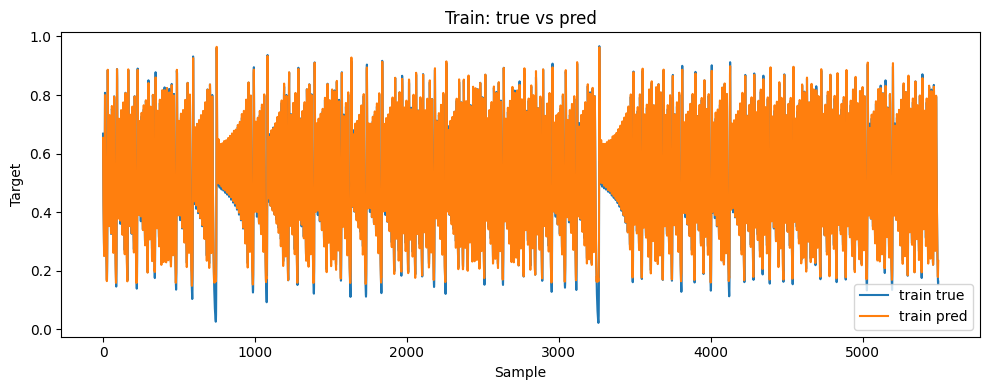

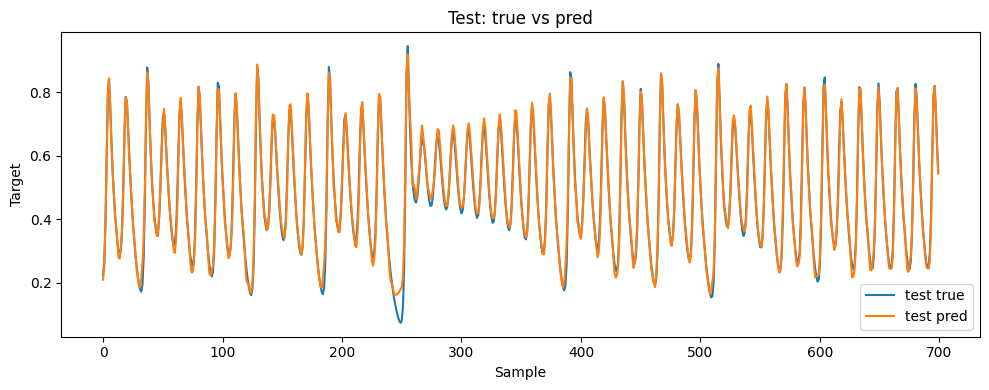

In [ ]:
#load best model and make predictions
model = torch.load(path,weights_only=False, map_location="cpu")

device = next(model.parameters()).device
dtype = next(model.parameters()).dtype

def to_torch(x):
    x = np.asarray(x)
    if np.iscomplexobj(x) and dtype.is_floating_point:
        x = x.real
    t = torch.from_numpy(x)
    if t.dtype == torch.float64 and dtype == torch.float32:
        t = t.float()
    if t.dtype == torch.complex128 and dtype == torch.complex64:
        t = t.to(torch.complex64)
    return t.to(device=device, dtype=dtype)

xpos_train_t = to_torch(xpos_train)
xneg_train_t = to_torch(xneg_train)
xpos_test_t  = to_torch(xpos_final)
xneg_test_t  = to_torch(xneg_final)

with torch.no_grad():
    y_tr_pred_t = model(xpos_train_t, xneg_train_t)
    y_te_pred_t = model(xpos_test_t,  xneg_test_t)

y_tr_pred = y_tr_pred_t.squeeze(-1).detach().cpu().numpy()
y_te_pred = y_te_pred_t.squeeze(-1).detach().cpu().numpy()

y_tr_true = y_train_torch.detach().cpu().numpy()
y_te_true = y_final_t.detach().cpu().numpy()

plt.figure(figsize=(10,4))
plt.plot(y_tr_true[100:70000], label="train true")
plt.plot(y_tr_pred[100:70000], label="train pred")
plt.xlabel("Sample"); plt.ylabel("Target"); plt.title("Train: true vs pred")
plt.legend(); plt.tight_layout()

plt.figure(figsize=(10,4))
plt.plot(y_te_true[100:], label="test true")
plt.plot(y_te_pred[100:], label="test pred")
plt.xlabel("Sample"); plt.ylabel("Target"); plt.title("Test: true vs pred")
plt.legend(); plt.tight_layout()